In [1]:
import brahmap
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import litebird_sim as lbs

## Producing the input maps, pointings and TOD using litebird_sim

In [2]:
telescope = "MFT"
channel = "M1-195"
detectors = [
    "001_002_030_00A_195_B",
    "001_002_029_45B_195_B",
    "001_002_015_15A_195_T",
    "001_002_047_00A_195_B",
]
start_time = 51
mission_time_days = 30
detector_sampling_freq = 1

nside = 128
random_seed = 45
imo_version = "vPTEP"
imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)
dtype_float = np.float64
tmp_dir = ".test"

In [3]:
sim = lbs.Simulation(
    random_seed=random_seed,
    base_path=tmp_dir,
    name="brahmap_example",
    start_time=start_time,
    duration_s=mission_time_days * 24 * 60 * 60.0,
    imo=imo,
)

sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

detector_list = []
for n_det in detectors:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = detector_sampling_freq
    detector_list.append(det)

sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

sim.create_observations(
    detectors=detector_list,
    num_of_obs_per_detector=3,
    n_blocks_det=1,
    n_blocks_time=1,
    split_list_over_processes=False,
    tod_dtype=dtype_float,
)

sim.prepare_pointings()
sim.precompute_pointings(pointings_dtype=dtype_float)

In [4]:
ch_info = []
n_ch_info = lbs.FreqChannelInfo.from_imo(
    imo,
    f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
)
ch_info.append(n_ch_info)

mbs_params = lbs.MbsParameters(
    make_cmb=True,
    make_fg=False,
    seed_cmb=1,
    gaussian_smooth=True,
    bandpass_int=False,
    nside=nside,
    units="uK_CMB",
    maps_in_ecliptic=False,
    output_string="mbs_cmb_lens",
)

mbs_obj = lbs.Mbs(
    simulation=sim,
    parameters=mbs_params,
    channel_list=ch_info,
)

input_maps = mbs_obj.run_all()

lbs.scan_map_in_observations(
    sim.observations,
    maps=input_maps[0][channel],
)

[2025-05-22 16:35:19,676 INFO MPI#0000] generating and saving cmb simulations
[2025-05-22 16:35:19,697 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2025-05-22 16:35:19,697 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2025-05-22 16:35:19,724 INFO MPI#0000] Access data from /home/ggalloni/Projects/GitHub/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_mbs_cmb_lens.fits
[2025-05-22 16:35:19,726 INFO MPI#0000] NSIDE = 128
[2025-05-22 16:35:19,727 INFO MPI#0000] ORDERING = RING in fits file
[2025-05-22 16:35:19,727 INFO MPI#0000] INDXSCHM = IMPLICIT
[2025-05-22 16:35:19,812 INFO MPI#0000] Sigma is 11.890505 arcmin (0.003459 rad) 
[2025-05-22 16:35:19,812 INFO MPI#0000] -> fwhm is 28.000000 arcmin
[2025-05-22 16:35:19,816 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2025-05-22 16:35:19,816 INFO MPI#0000] -> fwhm is 0.000000 arcmin


Here, we use a simple inverse covariance for uncorrelated white noise. Soon more choices will be available (e.g. circulant).

In [5]:
inv_cov = brahmap.LBSim_InvNoiseCovLO_UnCorr(sim.observations)

[2025-05-22 16:35:21,337 INFO MPI#0000] New linear operator with shape (10368000, 10368000)


### GLS mapmaking step

In [6]:
gls_results = sim.make_brahmap_gls_map(nside=nside, inv_noise_cov_operator=inv_cov)

[2025-05-22 16:35:22,506 INFO MPI#0000] New linear operator with shape (10368000, 369288)
[2025-05-22 16:35:22,507 INFO MPI#0000] New linear operator with shape (369288, 10368000)
[2025-05-22 16:35:22,507 INFO MPI#0000] New linear operator with shape (369288, 369288)
[2025-05-22 16:35:22,508 INFO MPI#0000] New linear operator with shape (369288, 10368000)
[2025-05-22 16:35:22,508 INFO MPI#0000] New linear operator with shape (10368000, 369288)
[2025-05-22 16:35:22,559 INFO MPI#0000] New linear operator with shape (369288, 10368000)
[2025-05-22 16:35:22,559 INFO MPI#0000] New linear operator with shape (10368000, 369288)
[2025-05-22 16:35:22,559 INFO MPI#0000] New linear operator with shape (369288, 369288)
[2025-05-22 16:35:22,560 INFO MPI#0000] New linear operator with shape (369288, 369288)



-------------------------- ProcessTimeSamples Summary --------------------------
Processed 10368000 time samples for npix=196608
Found 73512 pathological pixels on the map
Map-maker will take into account only 123096 pixels
--------------------------------------------------------------------------------


### Plotting I, Q and U

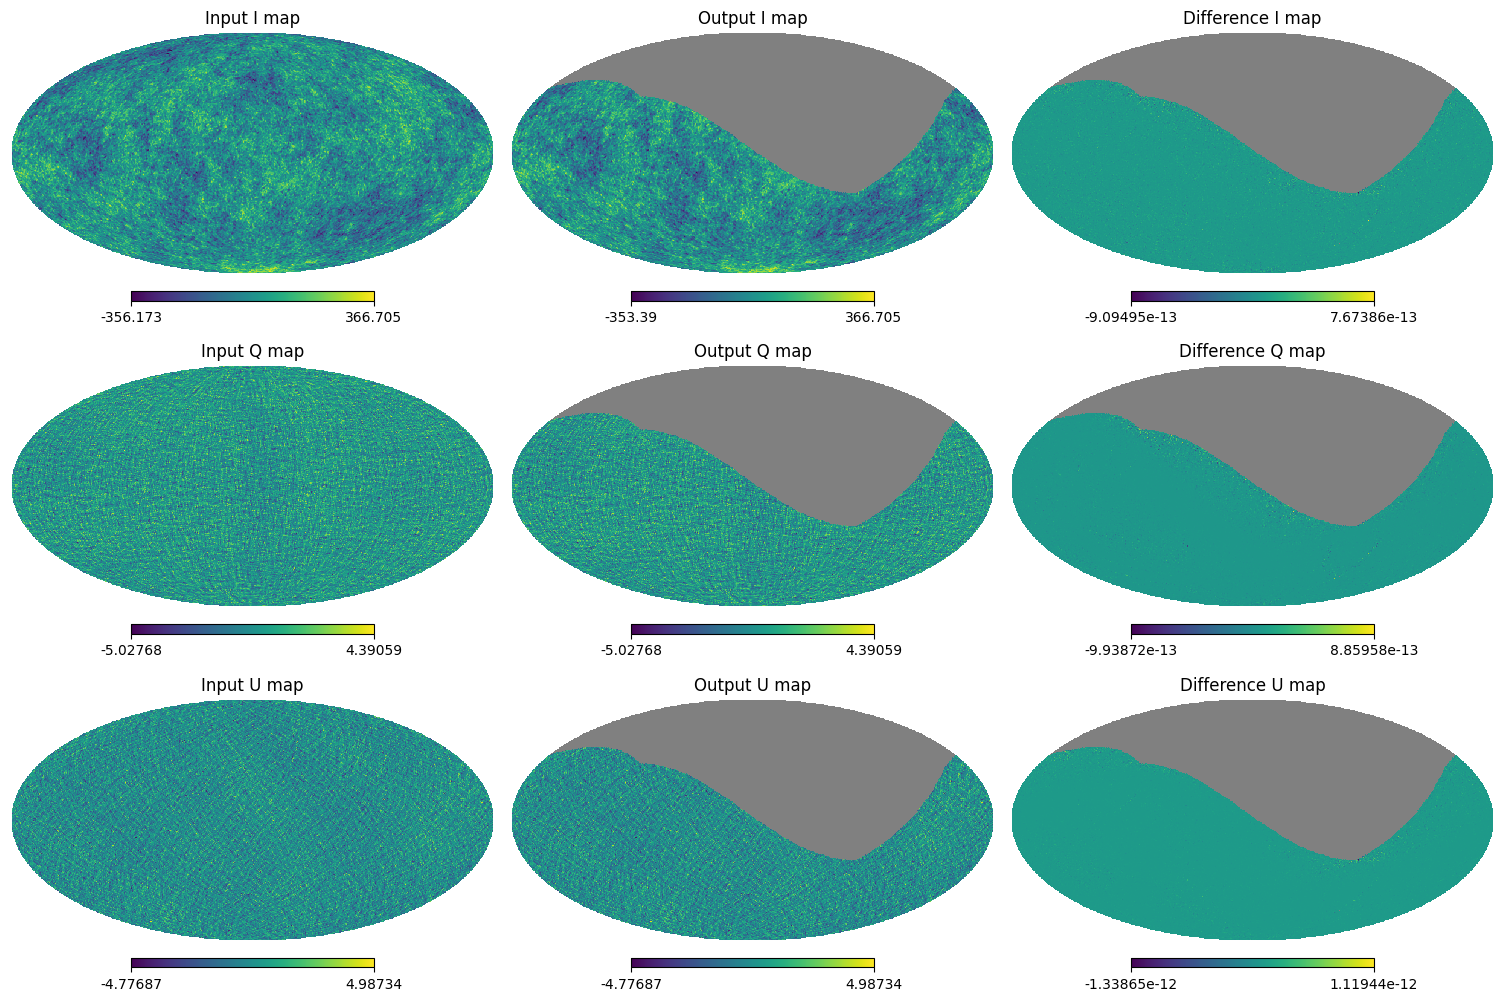

In [7]:
plt.figure(figsize=(15, 10))

hp.mollview(input_maps[0][channel][0], sub=331, title="Input I map")
hp.mollview(gls_results.GLS_maps[0], sub=332, title="Output I map")
hp.mollview(
    input_maps[0][channel][0] - gls_results.GLS_maps[0],
    sub=333,
    title="Difference I map",
)

hp.mollview(input_maps[0][channel][1], sub=334, title="Input Q map")
hp.mollview(gls_results.GLS_maps[1], sub=335, title="Output Q map")
hp.mollview(
    input_maps[0][channel][1] - gls_results.GLS_maps[1],
    sub=336,
    title="Difference Q map",
)

hp.mollview(input_maps[0][channel][2], sub=337, title="Input U map")
hp.mollview(gls_results.GLS_maps[2], sub=338, title="Output U map")
hp.mollview(
    input_maps[0][channel][2] - gls_results.GLS_maps[2],
    sub=339,
    title="Difference U map",
)